In [175]:
import pandas as pd
import seaborn as sns
import glob
import numpy as np
import matplotlib as mpl
# Some preprocessing utilities
from sklearn.cross_validation import train_test_split # Data splitting
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
# Model result function
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn import preprocessing
from sklearn.utils import shuffle
import itertools
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from collections import Counter

sns.set_context('paper',font_scale=2.)
sns.set_style("ticks",)
palette = sns.plt.cm.gray_r
# set masked values to plot red
palette.set_bad('r', 1.0)

In [176]:
data_files = shuffle(list(glob.glob("HH*13333*pks1613*0and1*csv")))#+ list(glob.glob("VV*133*pks1613*0and1*csv")))
print data_files

['HH1333305511_pks1613-586.1822.ms_all_data_baseline0and1.csv']


In [177]:
datasets = []
for filename in shuffle(data_files[:])[:]:
    data = pd.DataFrame.from_csv(filename)
    if len(np.where(data["rfi"].values == 1)[0])/float(len(data["rfi"])) < 0.4:
        datasets.append(data)
        print filename
    del data
X0 = pd.concat(datasets, ignore_index=True)
del datasets

HH1333305511_pks1613-586.1822.ms_all_data_baseline0and1.csv


In [178]:
names = ["d_p","tC_mean","tp_mean",'t_skew','t_kurtosis','t_cumsumx','t_sumvalues'
         ,'t_slope','t_per25','t_per75','t_var',"fC_mean","fp_mean",'f_skew'
         ,'f_kurtosis','f_cumsumx','f_sumvalues','f_slope','f_per25','f_per75','f_var']
best_features = ["tC_mean","tp_mean",'t_per25',
                 't_per75','t_sumvalues',
                 't_var','t_cumsumx']
target_names = ['Not RFI','RFI']

In [179]:
for i in range(10):
    X0= shuffle(X0)
HH_X0_not = X0[X0["rfi"]==0]
HH_X0_is = X0[X0["rfi"]==1]
X0 = pd.concat([HH_X0_not[:],HH_X0_is[:]], ignore_index=True)
del HH_X0_not
del HH_X0_is
X0 = X0.drop_duplicates()
print "RFI: {} \t not RFI: {}".format(len(X0[X0.rfi == 1]),len(X0[X0.rfi == 0]))

RFI: 2648 	 not RFI: 462952


In [180]:
x_train0, x_test0, y_train0, y_test0 = train_test_split(X0[names], X0['rfi'], test_size=0.30,random_state=0)

In [181]:
pairs = list(itertools.combinations(names,2))
len(pairs)

210

In [183]:
os = TomekLinks(ratio='not minority', n_jobs=-1)#RandomUnderSampler(ratio=0.35, random_state=1)
x_train_res, y_train_res = os.fit_sample(x_train0, y_train0)


In [184]:
print  "Distribution of class labels before resampling {}".format(Counter(y_train0))
print  "Distribution of class labels after resampling  {}".format(Counter(y_train_res))
clf_base = RandomForestClassifier(random_state = 0, n_jobs=-1)
grid = {'n_estimators': np.arange(1, 200)
        ,'criterion': ['gini', 'entropy']
        ,'max_features':['sqrt','log2']
        ,'max_depth':np.arange(1,50)
        ,'min_samples_split':np.arange(1,50)}

Distribution of class labels before resampling Counter({0: 324081, 1: 1839})
Distribution of class labels after resampling  Counter({0: 323713, 1: 1839})


In [185]:
cv = StratifiedKFold(y=y_train_res,shuffle=True,n_folds=2,random_state=0)
clf = RandomizedSearchCV(clf_base, grid, cv=cv,n_iter=1)
clf.fit(x_train_res, y_train_res)

RandomizedSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=2, shuffle=True, random_state=0),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'n_estimators': array([  1,   2, ..., 198, 199]), 'max_features': ['sqrt', 'log2'], 'min_samples_split': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 3...27, 28, 29, 30, 31, 32, 33, 34,
       35, 

In [186]:
rfc = clf.best_estimator_

In [187]:
X_train_res = pd.DataFrame(x_train_res, columns = list(names))
X_train_res['rfi'] = y_train_res

0 1 2

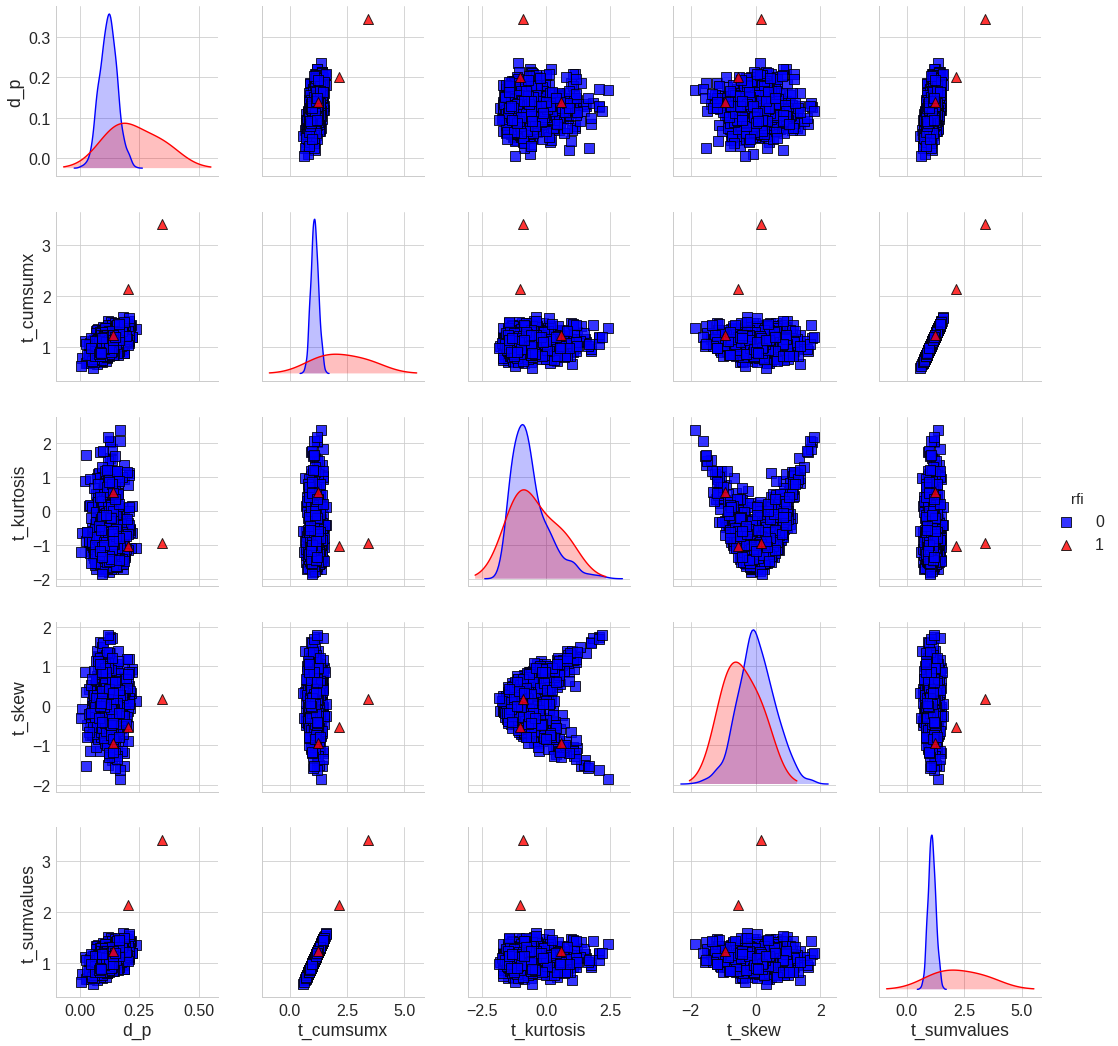

In [192]:
for i in range(3):
    print i,
    if i > 0:
        sns.plt.close()
    sns.plt.figure()
    sns.set_style("whitegrid")
    sns.pairplot(shuffle(X_train_res)[:800], size=3 ,diag_kind="kde",hue="rfi",palette=["b","r"],
                 vars=np.unique(list(itertools.combinations(names,2))[i:i+4]),markers=["s","^"],
                 plot_kws=dict(s=100, edgecolor="k", linewidth=1,alpha=0.8,),
                 diag_kws=dict(shade=True))
    #sns.pairplot(X0[X0.rfi==1][:5], diag_kind="kde",markers='^')
    sns.plt.savefig("Results/Models/HH-Features_"+str(i)+"tomek.eps",dpi=600)
sns.plt.show()

In [189]:
model_acc_rfc = []
#model_acc_gnb = []
#model_acc_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X_train_res)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[best_features], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = rfc
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acc_rfc.append(classifier_accuracy)
    
    #decision_tree_classifier = GaussianNB()
    #decision_tree_classifier.fit(training_inputs, training_classes)
    #classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    #model_acc_gnb.append(classifier_accuracy)
    
    #decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    #decision_tree_classifier.fit(training_inputs, training_classes)
    #classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    #model_acc_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

0 10 20 30 40 50 60 70 80 90


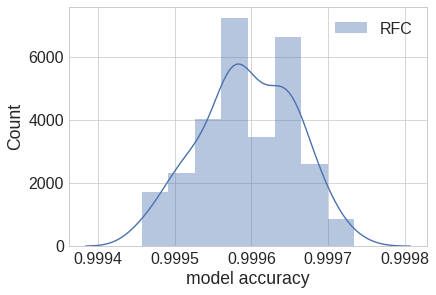

RFC: Mean 0.999594946041	std 6.12684549155e-05


In [193]:
sns.distplot(model_acc_rfc,label="RFC")
#sns.distplot(model_acc_knn,label="KNN")
#sns.distplot(model_acc_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.savefig("Results/Models/HH-average-tomek.eps",dpi=600)
sns.plt.grid(True)
sns.plt.show()
#with open("HH-average.txt","a+") as f:
#    f.write("RFC: Mean {0}\tstd {1} \n".format(np.mean(model_acc_rfc),np.std(model_acc_rfc)))
#    f.write("KNN: Mean {0}\tstd {1} \n".format(np.mean(model_acc_knn),np.std(model_acc_knn)))
#    f.write("NB:  Mean {0}\tstd {1} \n".format(np.mean(model_acc_gnb),np.std(model_acc_gnb)))
print "RFC: Mean {0}\tstd {1}".format(np.mean(model_acc_rfc),np.std(model_acc_rfc))
#print "KNN: Mean {0}\tstd {1}".format(np.mean(model_acc_knn),np.std(model_acc_knn))
#print "NB:  Mean {0}\tstd {1}".format(np.mean(model_acc_gnb),np.std(model_acc_gnb))



In [194]:
#cv = StratifiedKFold(y=y_train0,shuffle=True,n_folds=2,random_state=0)

#gnb = GaussianNB()
#grid = {"prior": np.resize([None],4)}
#gnb = RandomizedSearchCV(gnb, grid,cv=cv, n_jobs=-1)

#rfc = RandomForestClassifier(random_state=0,n_jobs=-1)
#grid = {'n_estimators': np.arange(1, 30)
#        ,'criterion': ['gini', 'entropy']
#        ,'max_features':['sqrt','log2']
#        ,'max_depth':np.arange(1,30)
#        ,'min_samples_split':np.arange(1,30)}
#rfc = RandomizedSearchCV(rfc, grid, cv=cv,n_iter=30)

#knn = KNeighborsClassifier()
#grid = {"n_neighbors": np.arange(1, 30, 2)
#        ,"metric": ["euclidean", "minkowski"]}
#knn = RandomizedSearchCV(knn, grid, cv=cv,n_iter=30)

In [195]:
#gnb.fit(x_train0,y_train0)

In [196]:
#rfc.fit(x_train_res,y_train_res)

In [197]:
#knn.fit(x_train0,y_train0)

In [198]:
#y_pred_prob_gnb = gnb.predict_proba(x_test0)
y_pred_prob_rfc = rfc.predict_proba(x_test0[best_features])
#y_pred_prob_knn = knn.predict_proba(x_test0)
#y_pred_gnb = gnb.predict(x_test0)
y_pred_rfc = rfc.predict(x_test0[best_features])
#y_pred_knn = knn.predict(x_test0)#

In [199]:
#def report(results,num, n_top=3):
    #n_top = len(results['rank_test_score']) -1
##    for i in range(1, n_top + 1):
#        candidates = np.flatnonzero(results['rank_test_score'] == i)
#        for candidate in candidates:
#            f.write("Model with rank: {0} \n".format(i))
 #           f.write("Mean validation score: {0:.3f} (std: {1:.3f}) \n".format(
 #                 results['mean_test_score'][candidate],
 #                 results['std_test_score'][candidate]))
 #           f.write("Parameters: {0} \n".format(results['params'][candidate]))
 #           f.write("--- \n")
 #   f.close()
 #   print("Model with rank: {0}".format(i))
 #   print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
 #         results['mean_test_score'][candidate],
 #         results['std_test_score'][candidate]))
 #   print("Parameters: {0}".format(results['params'][candidate]))
 #   print("")

In [200]:
#report(gnb.cv_results_)

In [201]:
#report(rfc.cv_results_,"RFC",n_top=len(rfc.cv_results_['rank_test_score'])-1)

In [202]:
#report(knn.cv_results_,"KNN",n_top=len(knn.cv_results_['rank_test_score'])-1)

In [203]:
#rfc=rfc.best_estimator_
#knn=knn.best_estimator_

In [204]:
def roc_plot(classifiers,subplot,model_names):
    #c = ['r','g','b']
    if subplot == True:
        num = len(classifiers)
        sns.plt.figure()
        for i in range(num):
            sns.plt.subplot(1,num,i+1)
            clf = classifiers[i]
            y_roc_fpr, y_roc_tpr, y_roc_thresholds = roc_curve(y_test0, clf[:,1])
            sns.plt.plot(y_roc_fpr, y_roc_tpr,label=model_names[i]+' AUC = %0.2f'% auc(y_roc_fpr, y_roc_tpr))
            sns.plt.legend(loc='lower right')
            sns.plt.plot([0,1],[0,1],'r--')
            sns.plt.xlim([-0.1,1.2])
            sns.plt.ylim([-0.1,1.2])
            sns.plt.ylabel('True Positive Rate')
            sns.plt.xlabel('False Positive Rate')
    if subplot == False:
        num = len(classifiers)
        sns.plt.figure()
        for i in range(num):
            clf = classifiers[i]
            y_roc_fpr, y_roc_tpr, y_roc_thresholds = roc_curve(y_test0, clf[:,1])
            sns.plt.plot(y_roc_fpr, y_roc_tpr,label=model_names[i]+' AUC = %0.2f'% auc(y_roc_fpr, y_roc_tpr))
            sns.plt.legend(loc='lower right')
            sns.plt.plot([0,1],[0,1],'r--')
            sns.plt.xlim([-0.1,1.2])
            sns.plt.ylim([-0.1,1.2])
            sns.plt.ylabel('True Positive Rate')
            sns.plt.xlabel('False Positive Rate')
    return

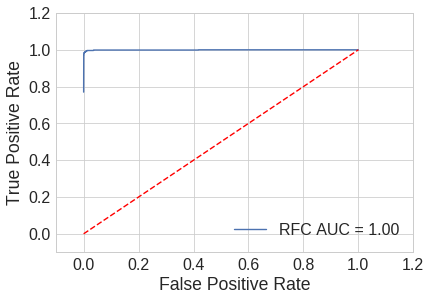

In [205]:
model_names =['RFC']#,'KNN','NB']
roc_plot([y_pred_prob_rfc],False,model_names)#y_pred_prob_knn,y_pred_prob_gnb
sns.plt.grid(True)
sns.plt.savefig("Results/Models/HH-ROC-tomek.eps",dpi=600)
sns.plt.show()

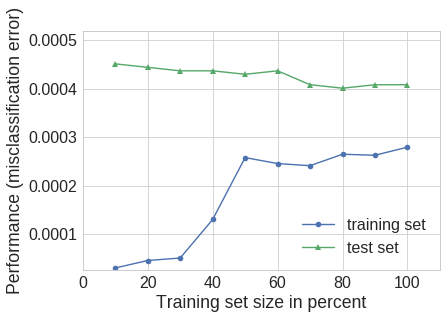

In [206]:
sns.plt.figure()
plot_learning_curves(x_train_res, y_train_res, x_test0.values, y_test0.values, rfc
                     ,print_model=False,style="seaborn-whitegrid")
sns.plt.savefig("Results/Models/HH-RFC_learning_curve-tomek.png",dpi=300)
#sns.plt.figure()
#plot_learning_curves(x_train0.values, y_train0.values, x_test0.values, y_test0.values, knn
#                     ,print_model=False,style="seaborn-whitegrid")
#sns.plt.savefig("Results/HH/HH-KNN_learning_curve.png",dpi=300)
#sns.plt.figure()
#plot_learning_curves(x_train0.values, y_train0.values, x_test0.values, y_test0.values, gnb
#                     ,print_model=False,style="seaborn-whitegrid")
#sns.plt.savefig("Results/HH/HH-NB_learning_curve.png",dpi=300)

sns.plt.show()

In [207]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=sns.plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #sns.plt.title(title)
    #sns.plt.colorbar()
    tick_marks = np.arange(len(classes))
    sns.plt.xticks(tick_marks, classes, rotation=45)
    sns.plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        sns.plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    sns.plt.tight_layout()
    sns.plt.grid(False)
    sns.plt.ylabel('True label')
    sns.plt.xlabel('Predicted label')
    
def evaluate(model,modelname):
    f = open("Results/HH/HH-Classification_report.txt","a+")
    for i in range(len(models)):
        # Do the actual prediction
        
        
        print('====================================================')
        print('Classification Report for %s'%modelname[i])
        print('====================================================')
        print(classification_report(y_test0,model[i],target_names=['Not RFI','RFI']))

        print('\n The model is %f accurate' %(accuracy_score(y_test0,model[i])*100))
        #f.write('==================================================== \n')
        #f.write('Classification Report for %s \n'%modelname[i])
        #f.write('==================================================== \n')
        #f.write(classification_report(y_test0,model[i],target_names=['Not RFI','RFI']))

        #f.write('\n The model is %f accurate \n' %(accuracy_score(y_test0,model[i])*100))
        print('Confusion Matrix')
        cnf_matrix = confusion_matrix(y_test0,model[i])
        sns.plt.figure()
        #sns.plt.subplot(1,3,i+1)
        plot_confusion_matrix(cnf_matrix, classes=target_names)
                      #title='Confusion matrix')
        sns.plt.savefig("Results/Models/HH-"+str(modelname[i])+"_confusion-tomek.eps",dpi=600)
        #sns.plt.subplot(2,1,2)
        #plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True
        #                      ,title='Normalized confusion matrix')
        print('====================================================\n\n')
    f.close()

Classification Report for RFC
             precision    recall  f1-score   support

    Not RFI       1.00      1.00      1.00    138871
        RFI       0.99      0.94      0.96       809

avg / total       1.00      1.00      1.00    139680


 The model is 99.959908 accurate
Confusion Matrix




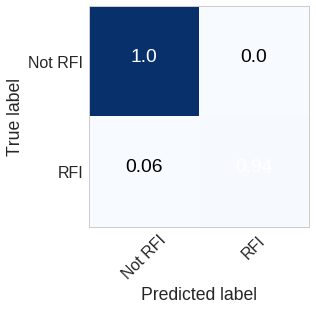

In [208]:
models =[y_pred_rfc]
model_names =['RFC']
#sns.plt.figure(figsize=(20,20))
evaluate(models,model_names)
sns.plt.show()

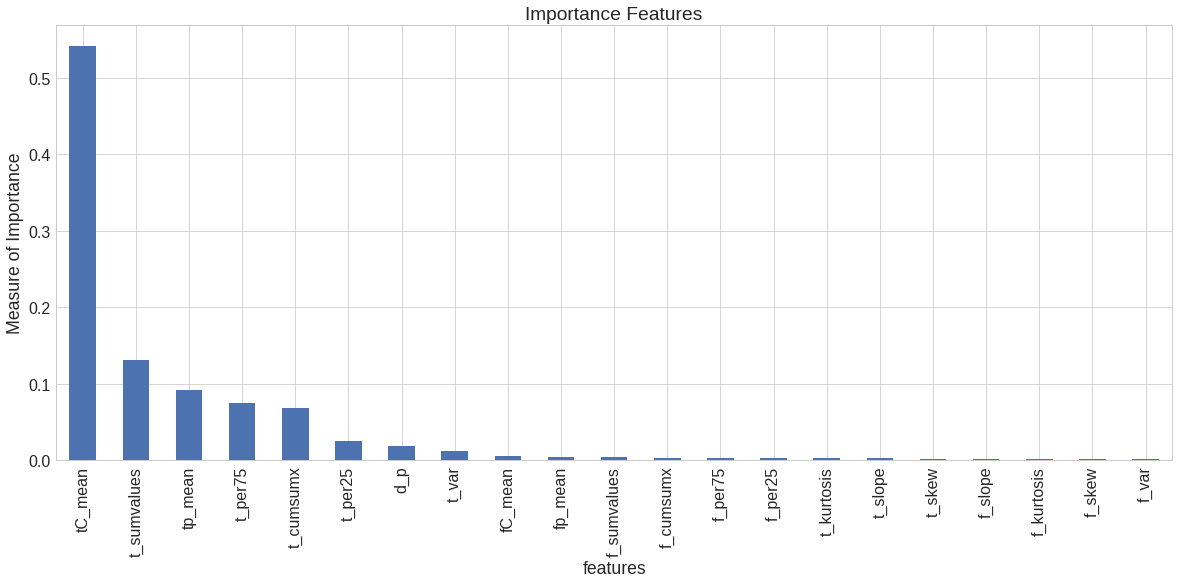

In [209]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_space= []
# Print the feature ranking
#o = open("Results/HH/HH-feature_rank.txt","a+")
#o.write("Feature ranking: \n")
impdf = []
for f in range(x_train0.shape[1]):
    #o.write("%d. feature %s (%f) \n" % (f + 1, names[indices[f]], importances[indices[f]]))
    feature_space.append(names[indices[f]])
    impdf.append({'features': names[indices[f]], 'importance': importances[indices[f]]})
##o.close()
impdf = pd.DataFrame(impdf)
impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
impdf['importance'] /= impdf['importance'].sum()
impdf.index = impdf['features']
sns.plt.figure()
impdf.plot(kind='bar', title='Importance Features', figsize=(20, 8),legend=False,fontsize=16.0)
sns.plt.ylabel("Measure of Importance")
sns.plt.grid(True)
#sns.plt.savefig("Results/HH/HH-feature_rank.png",dpi=300)
sns.plt.show()

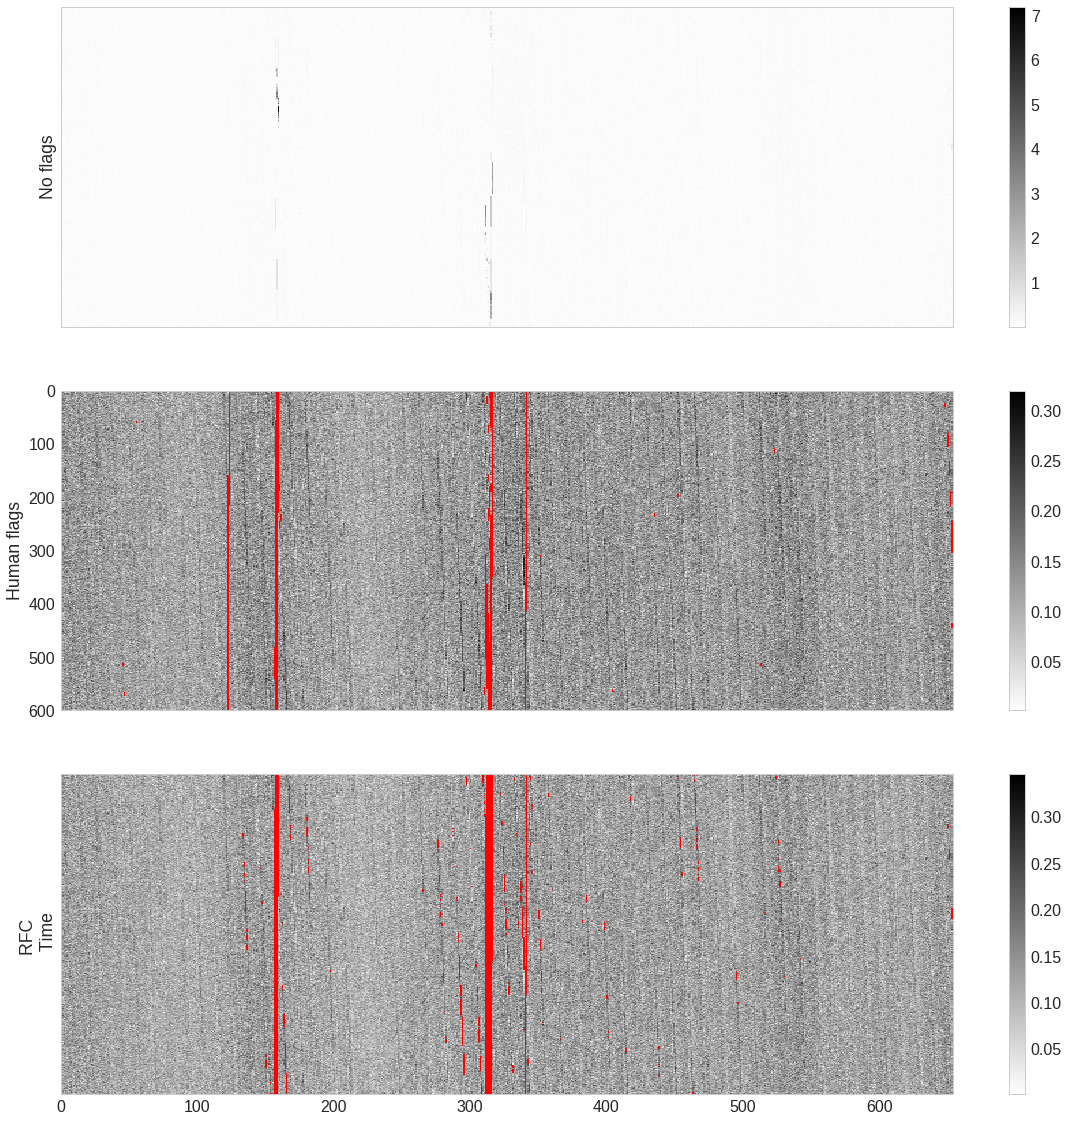

In [210]:
testVV = pd.DataFrame.from_csv('HH1333134985_pks1613-586.1822.ms_all_data_baseline0and2.csv')
rfi_rfc =rfc.predict(testVV[names])
#rfi_knn = knn.predict(testVV[names])
#rfi_gnb = gnb.predict(testVV[names])

image = np.reshape(testVV['d_p'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
org_flags = np.reshape(testVV['rfi'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
rfc_flags = np.reshape(rfi_rfc,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
#knn_flags = np.reshape(rfi_knn,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
#gnb_flags = np.reshape(rfi_gnb,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))


sns.plt.figure(figsize=(20,20))
sns.plt.subplot(3,1,1)
sns.plt.imshow(image.T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("No flags")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(3,1,2)
sns.plt.imshow(np.ma.array(image,mask=org_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Human flags")
sns.plt.xticks([])



sns.plt.subplot(3,1,3)
sns.plt.imshow(np.ma.array(image,mask=rfc_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Time")
#sns.plt.xlabel("Channels")
sns.plt.ylabel("RFC \n Time")
sns.plt.yticks([])
sns.plt.savefig("Results/Models/seen_HH-model_flags2-tomek.eps",dpi=600)
sns.plt.show()

In [156]:
np.sum(knn_flags == 1,dtype=float)/len(np.ravel(knn_flags))

0.36200185882032915

In [157]:
time = 0

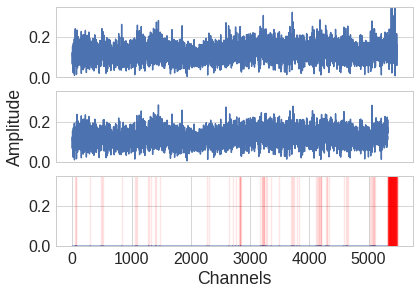

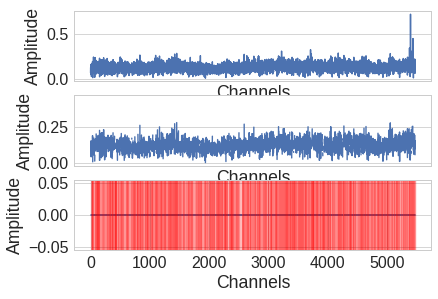

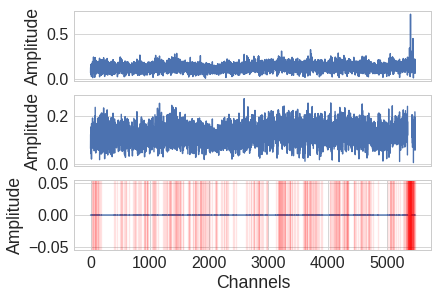

In [158]:
time = time + 40
sns.plt.figure()
sns.plt.subplot("311")
sns.plt.plot((image[:,time]))
#sns.plt.xlabel("Channels")
#sns.plt.ylabel("Amplitude")
sns.plt.xticks([])
sns.plt.ylim(0.0,0.35)
#sns.plt.plot(np.log10(np.mean(image[:,:],axis=1)))
sns.plt.subplot("312")
sns.plt.plot((np.ma.array(image[:,time],mask=rfc_flags[:,time])))
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Amplitude")
sns.plt.xticks([])
sns.plt.ylim(0.0,0.35)

sns.plt.subplot("313")
sns.plt.plot((np.ma.array(image[:,time],mask=rfc_flags[:,time]) - image[:,time]))
sns.plt.xlabel("Channels")
#sns.plt.ylabel("Amplitude")
sns.plt.ylim(0.0,0.35)

for i in range(len(image[:,time])):
    if rfc_flags[i,time] == 1:
        sns.plt.axvline(i,alpha=0.1,color='r')

sns.plt.figure()
sns.plt.subplot("311")
sns.plt.plot((image[:,time]))
sns.plt.xlabel("Channels")
sns.plt.ylabel("Amplitude")
sns.plt.xticks([])
#sns.plt.plot(np.log10(np.mean(image[:,:],axis=1)))
sns.plt.subplot("312")
sns.plt.plot((np.ma.array(image[:,time],mask=knn_flags[:,time])))
sns.plt.xlabel("Channels")
sns.plt.ylabel("Amplitude")
sns.plt.xticks([])

sns.plt.subplot("313")
sns.plt.plot((np.ma.array(image[:,time],mask=knn_flags[:,time]) - image[:,time]))
sns.plt.xlabel("Channels")
sns.plt.ylabel("Amplitude")

for i in range(len(image[:,time])):
    if knn_flags[i,time] == 1:
        sns.plt.axvline(i,alpha=0.1,color='r')

sns.plt.figure()
sns.plt.subplot("311")
sns.plt.plot((image[:,time]))
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Amplitude")
sns.plt.xticks([])
#sns.plt.plot(np.log10(np.mean(image[:,:],axis=1)))
sns.plt.subplot("312")
sns.plt.plot((np.ma.array(image[:,time],mask=gnb_flags[:,time])))
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Amplitude")
sns.plt.xticks([])

sns.plt.subplot("313")
sns.plt.plot((image[:,time]-np.ma.array(image[:,time],mask=gnb_flags[:,time])))
sns.plt.xlabel("Channels")
sns.plt.ylabel("Amplitude")

for i in range(len(image[:,time])):
    if gnb_flags[i,time] == 1:
        sns.plt.axvline(i,alpha=0.1,color='r')



sns.plt.show()

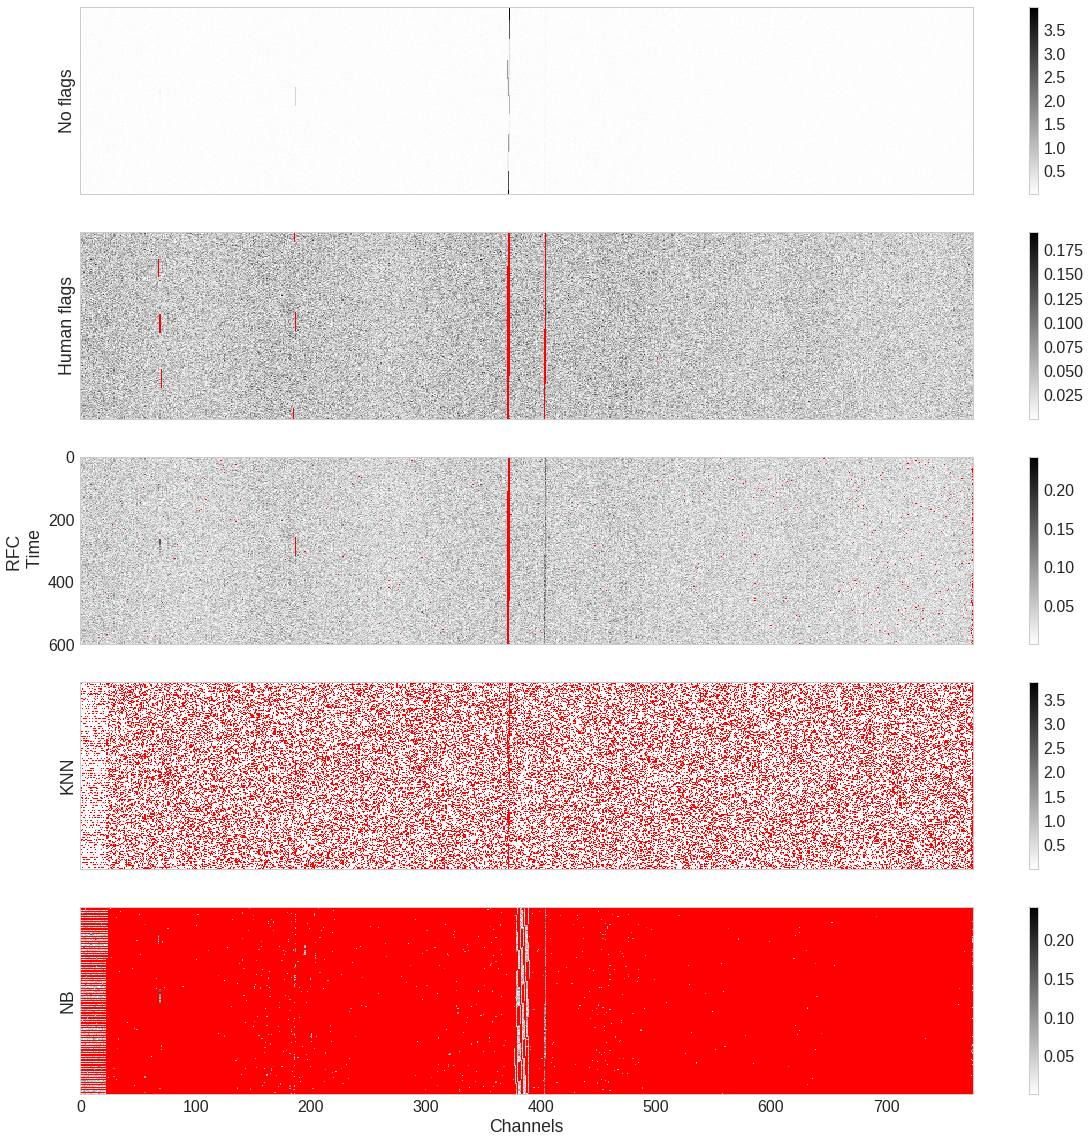

In [171]:
testVV = pd.DataFrame.from_csv('VV1333305511_pks1613-586.1822.ms_all_data_baseline0and1.csv')
rfi_rfc =rfc.predict(testVV[names])
rfi_knn = knn.predict(testVV[names])
rfi_gnb = gnb.predict(testVV[names])

image = np.reshape(testVV['d_p'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
org_flags = np.reshape(testVV['rfi'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
rfc_flags = np.reshape(rfi_rfc,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
knn_flags = np.reshape(rfi_knn,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
gnb_flags = np.reshape(rfi_gnb,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))


sns.plt.figure(figsize=(20,20))
sns.plt.subplot(5,1,1)
sns.plt.imshow(image.T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("No flags")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(5,1,2)
sns.plt.imshow(np.ma.array(image,mask=org_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Human flags")
sns.plt.xticks([])
sns.plt.yticks([])


sns.plt.subplot(5,1,3)
sns.plt.imshow(np.ma.array(image,mask=rfc_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Time")
#sns.plt.xlabel("Channels")
sns.plt.ylabel("RFC \n Time")
sns.plt.xticks([])


sns.plt.subplot(5,1,4)
sns.plt.imshow(np.ma.array(image,mask=knn_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("KNN")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(5,1,5)
sns.plt.imshow(np.ma.array(image,mask=gnb_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
sns.plt.xlabel("Channels")
sns.plt.ylabel("NB")
sns.plt.yticks([])
sns.plt.savefig("Results/HH/seen_VV-model_flags2.png",dpi=300)
sns.plt.show()

In [172]:
f = open("Results/HH/seen_VV-model_flags2.txt","a+")
f.write(" Data mean: {0} max: {1} std: {2} median: {3} \n".format(np.ma.mean(np.ma.array(image[:,:])),
                                                  np.ma.max(np.ma.array(image[:,:])),
                                                  np.ma.std(np.ma.array(image[:,:])),
                                                  np.ma.median(np.ma.array(image[:,:]))))

f.write(" Human mean: {0} max: {1} std: {2} median: {3} ratio: {4} \n".format(np.ma.mean(np.ma.array(image[:,:],mask=org_flags[:,:])),
                                                  np.ma.max(np.ma.array(image[:,:],mask=org_flags[:,:])),
                                                  np.ma.std(np.ma.array(image[:,:],mask=org_flags[:,:])),
                                                  np.ma.median(np.ma.array(image[:,:],mask=org_flags[:,:])),
                                                  np.sum(org_flags,dtype=float)/len(np.ravel(org_flags))))

f.write(" RFC mean: {0} max: {1} std: {2} median: {3} ratio: {4} \n".format(np.ma.mean(np.ma.array(image[:,:],mask=rfc_flags[:,:])),
                                                  np.ma.max(np.ma.array(image[:,:],mask=rfc_flags[:,:])),
                                                  np.ma.std(np.ma.array(image[:,:],mask=rfc_flags[:,:])),
                                                  np.ma.median(np.ma.array(image[:,:],mask=rfc_flags[:,:])),
                                                  np.sum(rfc_flags,dtype=float)/len(np.ravel(rfc_flags))))

f.write(" KNN mean: {0} max: {1} std: {2} median: {3} ratio: {4} \n".format(np.ma.mean(np.ma.array(image[:,:],mask=knn_flags[:,:])),
                                                  np.ma.max(np.ma.array(image[:,:],mask=knn_flags[:,:])),
                                                  np.ma.std(np.ma.array(image[:,:],mask=knn_flags[:,:])),
                                                  np.ma.median(np.ma.array(image[:,:],mask=knn_flags[:,:])),
                                                  np.sum(knn_flags,dtype=float)/len(np.ravel(knn_flags))))

f.write(" NB mean: {0} max: {1} std: {2} median: {3} ratio: {4} \n".format(np.ma.mean(np.ma.array(image[:,:],mask=gnb_flags[:,:])),
                                                  np.ma.max(np.ma.array(image[:,:],mask=gnb_flags[:,:])),
                                                  np.ma.std(np.ma.array(image[:,:],mask=gnb_flags[:,:])),
                                                  np.ma.median(np.ma.array(image[:,:],mask=gnb_flags[:,:])),
                                                  np.sum(gnb_flags,dtype=float)/len(np.ravel(gnb_flags))))

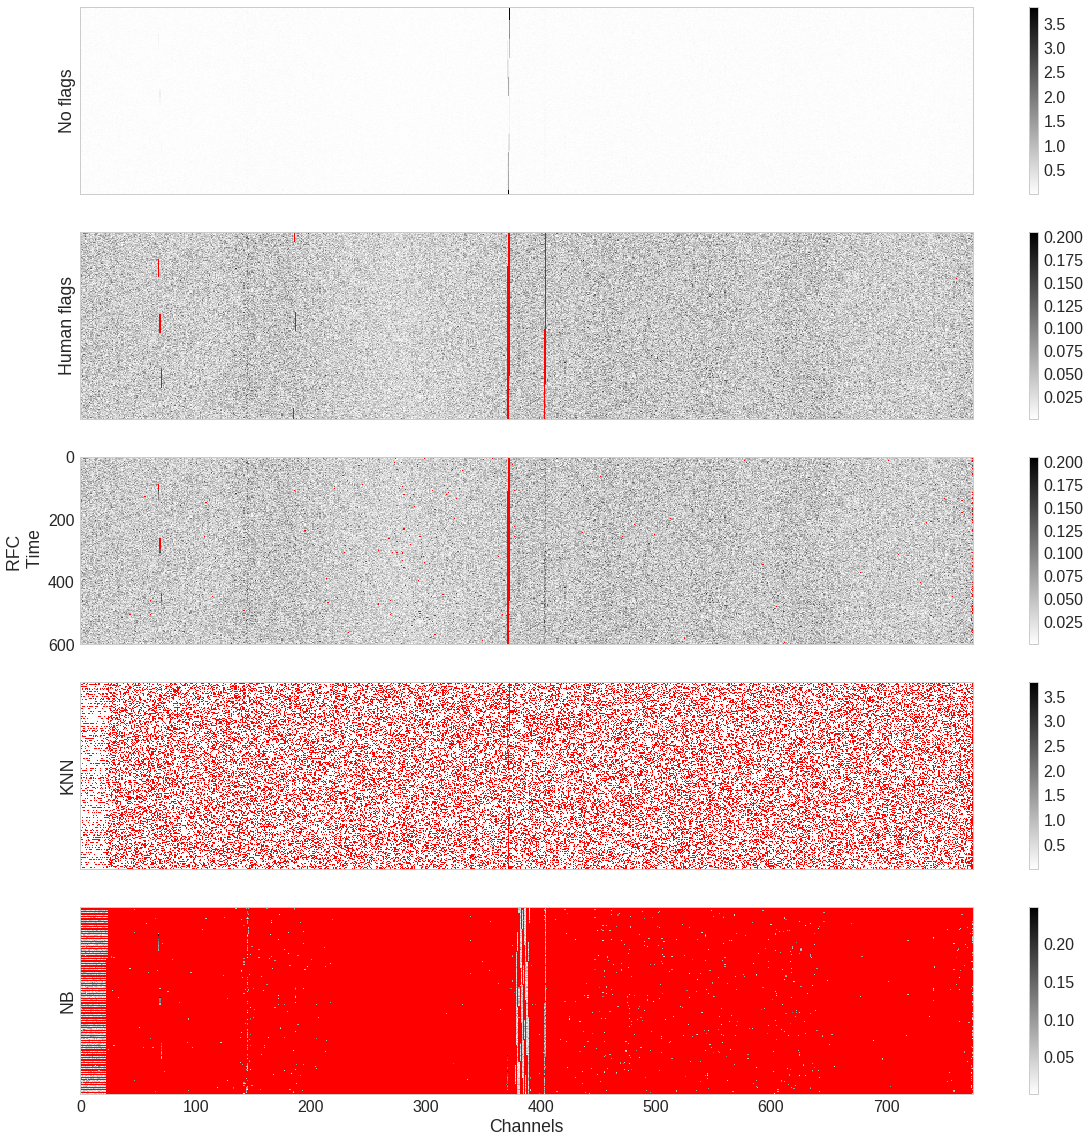

In [173]:
testVV = pd.DataFrame.from_csv('HV1333305511_pks1613-586.1822.ms_all_data_baseline0and1.csv')
rfi_rfc =rfc.predict(testVV[names])
rfi_knn = knn.predict(testVV[names])
rfi_gnb = gnb.predict(testVV[names])

image = np.reshape(testVV['d_p'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
org_flags = np.reshape(testVV['rfi'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
rfc_flags = np.reshape(rfi_rfc,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
knn_flags = np.reshape(rfi_knn,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
gnb_flags = np.reshape(rfi_gnb,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))


sns.plt.figure(figsize=(20,20))
sns.plt.subplot(5,1,1)
sns.plt.imshow(image.T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("No flags")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(5,1,2)
sns.plt.imshow(np.ma.array(image,mask=org_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Human flags")
sns.plt.xticks([])
sns.plt.yticks([])


sns.plt.subplot(5,1,3)
sns.plt.imshow(np.ma.array(image,mask=rfc_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Time")
#sns.plt.xlabel("Channels")
sns.plt.ylabel("RFC \n Time")
sns.plt.xticks([])


sns.plt.subplot(5,1,4)
sns.plt.imshow(np.ma.array(image,mask=knn_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("KNN")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(5,1,5)
sns.plt.imshow(np.ma.array(image,mask=gnb_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
sns.plt.xlabel("Channels")
sns.plt.ylabel("NB")
sns.plt.yticks([])
sns.plt.savefig("Results/HH/seen_HV-model_flags2.png",dpi=300)
sns.plt.show()

In [174]:
f = open("Results/HH/seen_HV-model_flags2.txt","a+")
f.write(" Data mean: {0} max: {1} std: {2} median: {3} \n".format(np.ma.mean(np.ma.array(image[:,:])),
                                                  np.ma.max(np.ma.array(image[:,:])),
                                                  np.ma.std(np.ma.array(image[:,:])),
                                                  np.ma.median(np.ma.array(image[:,:]))))

f.write(" Human mean: {0} max: {1} std: {2} median: {3} ratio: {4} \n".format(np.ma.mean(np.ma.array(image[:,:],mask=org_flags[:,:])),
                                                  np.ma.max(np.ma.array(image[:,:],mask=org_flags[:,:])),
                                                  np.ma.std(np.ma.array(image[:,:],mask=org_flags[:,:])),
                                                  np.ma.median(np.ma.array(image[:,:],mask=org_flags[:,:])),
                                                  np.sum(org_flags,dtype=float)/len(np.ravel(org_flags))))

f.write(" RFC mean: {0} max: {1} std: {2} median: {3} ratio: {4} \n".format(np.ma.mean(np.ma.array(image[:,:],mask=rfc_flags[:,:])),
                                                  np.ma.max(np.ma.array(image[:,:],mask=rfc_flags[:,:])),
                                                  np.ma.std(np.ma.array(image[:,:],mask=rfc_flags[:,:])),
                                                  np.ma.median(np.ma.array(image[:,:],mask=rfc_flags[:,:])),
                                                  np.sum(rfc_flags,dtype=float)/len(np.ravel(rfc_flags))))

f.write(" KNN mean: {0} max: {1} std: {2} median: {3} ratio: {4} \n".format(np.ma.mean(np.ma.array(image[:,:],mask=knn_flags[:,:])),
                                                  np.ma.max(np.ma.array(image[:,:],mask=knn_flags[:,:])),
                                                  np.ma.std(np.ma.array(image[:,:],mask=knn_flags[:,:])),
                                                  np.ma.median(np.ma.array(image[:,:],mask=knn_flags[:,:])),
                                                  np.sum(knn_flags,dtype=float)/len(np.ravel(knn_flags))))

f.write(" NB mean: {0} max: {1} std: {2} median: {3} ratio: {4} \n".format(np.ma.mean(np.ma.array(image[:,:],mask=gnb_flags[:,:])),
                                                  np.ma.max(np.ma.array(image[:,:],mask=gnb_flags[:,:])),
                                                  np.ma.std(np.ma.array(image[:,:],mask=gnb_flags[:,:])),
                                                  np.ma.median(np.ma.array(image[:,:],mask=gnb_flags[:,:])),
                                                  np.sum(gnb_flags,dtype=float)/len(np.ravel(gnb_flags))))